In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'phase_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)#,multi=False)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


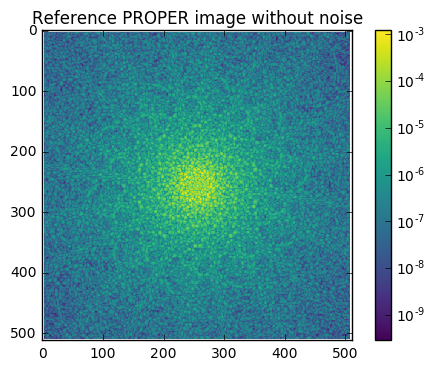

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

18838968.4702


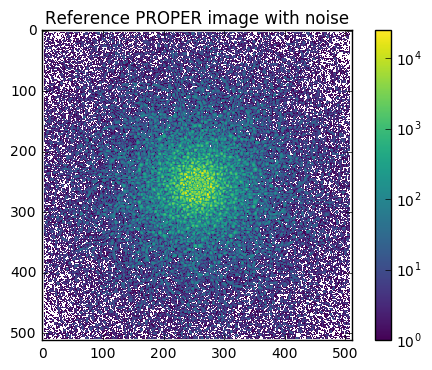

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

# Fit by tweaking telescope magnification

Let's assume that the model is correct, and that the only parameter that isn't well known is the spacing between the primary and secondary mirrors. Assume also that both the reference and model PSFs are at their corresponding focal planes. Optimise the model to minimise the error between the two detector images.

In [8]:
# Adapted from Barnaby's code for the lens equation 

#Fa = 0.5 * 1.143451
#Fb = -0.5 * 0.0467579189727913
#T = 0.549337630333726
def bfl(fa, fb, d):
    '''Calculate back focal length for a pair of lenses
    
    Parameters
    ----------
    fa: float
    primary lens focal length
    
    fb: float
    secondary lens focal length, in same units as fa
    
    d: float
    separation between primary and secondary lenses, in same units as fa and fb

    Returns
    -------
    Distance from secondary lens to focal plane
    '''
    # 1/f = 1/fa + 1/fb - d/(fa fb)
    f = (1./fa + 1./fb - d/(fa * fb))**-1
    # Assume thin lenses so BFL = F(Fa - T) / Fa
    return f*(fa - d) / fa

In [9]:
# Function to generate 
def model_err(sep, view=False):
    print('Trying with separation ', sep)
    settings = toliman_settings.copy()
    fa = settings['m1_fl']
    fb = settings['m2_fl']
    settings['m1_m2_sep'] = sep 
    b = bfl(fa, fb, sep)
    settings['bfl'] = b
    print('Calculated BFL ', b)
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - detector_image)**2)
    print('Error ', error)
    return error

## Sanity check

How does error value vary over reasonable range? 

Trying with separation  0.54
Calculated BFL  -0.0888439999999984


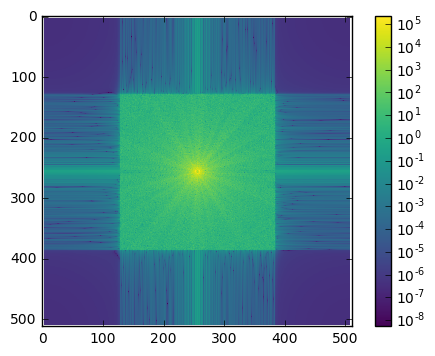

Error  469689452186.0
Trying with separation  0.545
Calculated BFL  -0.18655146268656098


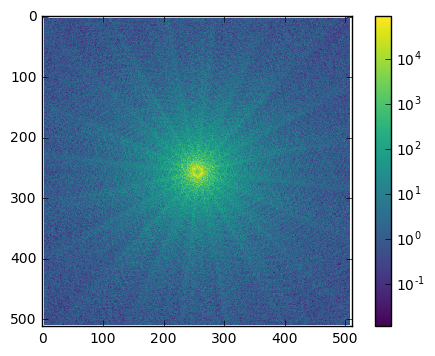

Error  248649036594.0
Trying with separation  0.55
Calculated BFL  0.30790751515152875


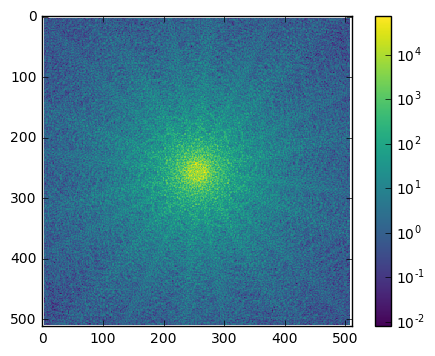

Error  193839618776.0
Trying with separation  0.555
Calculated BFL  0.058819157894737996


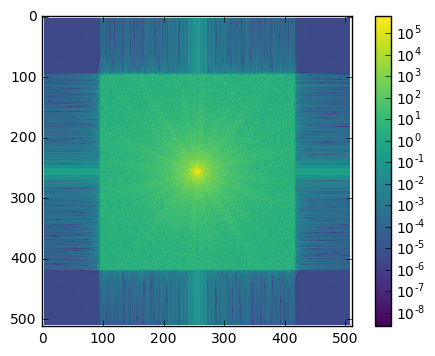

Error  1.95971808736e+12
Trying with separation  0.56
Calculated BFL  0.023540549356223364


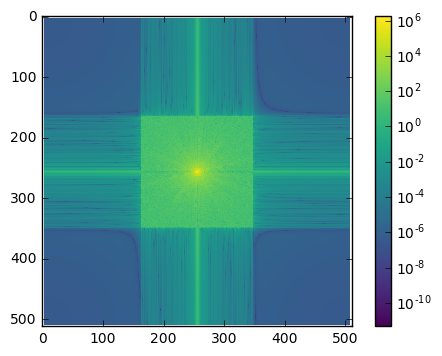

Error  8.7592511581e+12


In [10]:
errors = []
for sep in [0.54, 0.545, 0.55, 0.555, 0.56]:
    errors.append((sep,model_err(sep, view=True)))

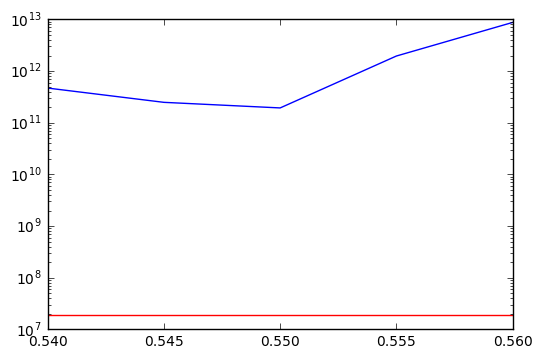

In [11]:
plt.plot(*zip(*errors))
plt.yscale('log')
plt.axhline(y=min_err, color='red')
plt.show()

## Optimize

### Least squares

In [12]:
from scipy.optimize import least_squares
sep_error = 0.01
sep_init = toliman_settings['m1_m2_sep']+sep_error
opt = least_squares(model_err, sep_init)

Trying with separation  [ 0.55924]
Calculated BFL  [ 0.02681508]
Error  8.66577735046e+12
Trying with separation  [ 0.55924001]
Calculated BFL  [ 0.02681501]
Error  8.66584137029e+12
Trying with separation  [ 0.55722297]
Calculated BFL  [ 0.0382256]
Error  3.47636675821e+12
Trying with separation  [ 0.55722298]
Calculated BFL  [ 0.0382255]
Error  3.4764092131e+12
Trying with separation  [ 0.5560028]
Calculated BFL  [ 0.048048]
Error  3.36300885531e+12
Trying with separation  [ 0.55600282]
Calculated BFL  [ 0.04804786]
Error  3.36303455562e+12
Trying with separation  [ 0.55569776]
Calculated BFL  [ 0.05101332]
Error  2.94484341803e+12
Trying with separation  [ 0.55569778]
Calculated BFL  [ 0.05101317]
Error  2.94486282574e+12
Trying with separation  [ 0.55508768]
Calculated BFL  [ 0.05774947]
Error  2.06644456111e+12
Trying with separation  [ 0.5550877]
Calculated BFL  [ 0.05774929]
Error  2.06646238232e+12
Trying with separation  [ 0.55386752]
Calculated BFL  [ 0.07569073]
Error  1.498

In [13]:
# How do things look now?
settings = toliman_settings.copy()
fa = settings['m1_fl']
fb = settings['m2_fl']
sep = opt.x[0]
print("Optimal separation {} differs from target by {}".format(sep, sep-sep_init))
settings['m1_m2_sep'] = sep 
b = bfl(fa, fb, sep)
settings['bfl'] = b
source = {
    'wavelengths': [wavelength],
    'weights': [1.],
        'settings': settings
    }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)

Optimal separation 0.5485317601666558 differs from target by -0.010708239833344235


In [14]:
final *= intensity_scale

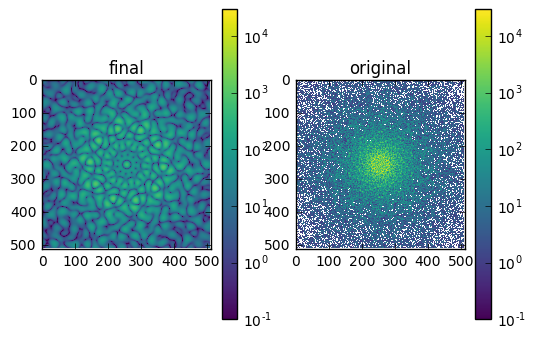

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [16]:
print("Final error {:.2e} vs. minimum bound of {:.2e}".format(np.sum((detector_image - final)**2), min_err))

Final error 6.91e+10 vs. minimum bound of 1.88e+07


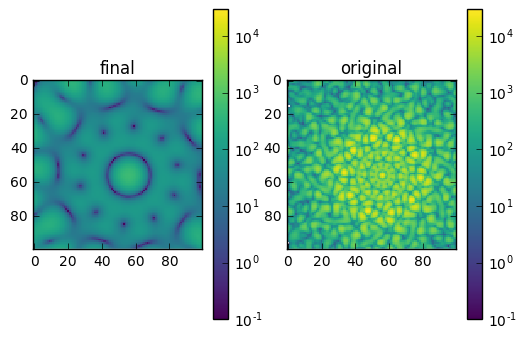

In [17]:
# zoom into central region
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

### Brent scalar minimization

In [18]:
from scipy.optimize import minimize_scalar
opt = minimize_scalar(model_err)

Trying with separation  0.0
Calculated BFL  -0.024376853104768847
Error  69632590533.0
Trying with separation  1.0
Calculated BFL  -0.02216971681611868
Error  69632590527.0
Trying with separation  2.6180339999999998
Calculated BFL  -0.023115889923292637
Error  69632590480.0
Trying with separation  5.2360680251559995
Calculated BFL  -0.023263392218331683
Error  69632590532.9
Trying with separation  2.6180339999999998
Calculated BFL  -0.023115889923292637
Error  69632590480.0
Trying with separation  3.6180339844527363
Calculated BFL  -0.023201928119386706
Error  69632590532.7
Trying with separation  2.000000025156
Calculated BFL  -0.023003446154012737
Error  69632590532.4
Trying with separation  2.80766855254
Calculated BFL  -0.0231380578447
Error  69632590532.8
Trying with separation  2.61803396124
Calculated BFL  -0.0231158899183
Error  69632590480.0
Trying with separation  2.61803392249
Calculated BFL  -0.0231158899134
Error  69632590480.0


### Bounded scalar

In [19]:
from scipy.optimize import minimize_scalar
opt = minimize_scalar(model_err, bounds=(0.54, 0.56), method='bounded')

Trying with separation  0.547639320225
Calculated BFL  -0.792537107365
Error  64807046818.2
Trying with separation  0.552360679775
Calculated BFL  0.112912207473
Error  814316600589.0
Trying with separation  0.54472135955
Calculated BFL  -0.174021654232
Error  281105520072.0
Trying with separation  0.54739617697
Calculated BFL  -0.59646786099
Error  44013928276.2
Trying with separation  0.546801329067
Calculated BFL  -0.376343556277
Error  108293326603.0
Trying with separation  0.547332646901
Calculated BFL  -0.560680570168
Error  76213584808.8
Trying with separation  0.547495611622
Calculated BFL  -0.663164451709
Error  31298358508.7
Trying with separation  0.547488953231
Calculated BFL  -0.658217060486
Error  25699289552.3
Trying with separation  0.547452017497
Calculated BFL  -0.632105000878
Error  9015820858.28
Trying with separation  0.547430688314
Calculated BFL  -0.61798181794
Error  16528364808.2
Trying with separation  0.54745535895
Calculated BFL  -0.63437856769
Error  900005

In [22]:
# How do things look now?
settings = toliman_settings.copy()
fa = settings['m1_fl']
fb = settings['m2_fl']
sep = opt.x
print("Optimal separation {} differs from target by {}".format(sep, sep-sep_init))
settings['m1_m2_sep'] = sep 
b = bfl(fa, fb, sep)
settings['bfl'] = b
source = {
    'wavelengths': [wavelength],
    'weights': [1.],
        'settings': settings
    }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)

Optimal separation 0.5474553589502398 differs from target by -0.011784641049760292


In [23]:
final *= intensity_scale

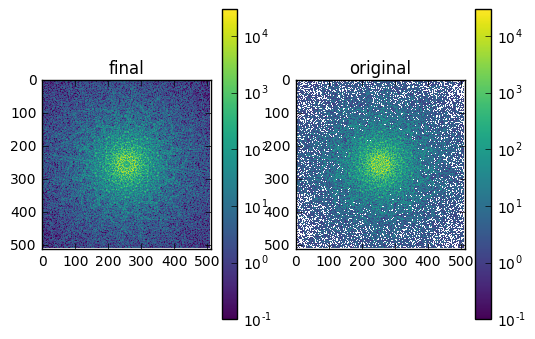

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [25]:
print("Final error {:.2e} vs. minimum bound of {:.2e}".format(np.sum((detector_image - final)**2), min_err))

Final error 9.00e+09 vs. minimum bound of 1.88e+07


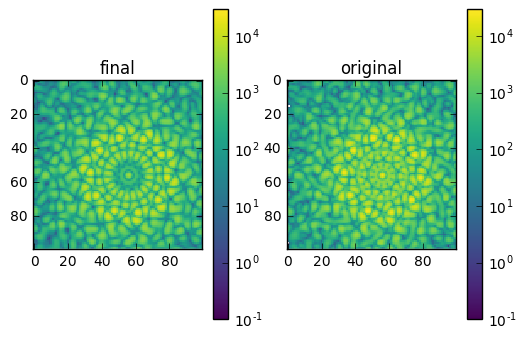

In [26]:
# zoom into central region
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()